# Estimating covariance matrix with biological information

In [1]:
#Importing
import os
import numpy             as np
import scipy             as sp
import pickle            as pkl
import tensorflow        as tf
#import matplotlib.pyplot as plt
import PWoptim           as pwo


from PWoptim.functions import *
from PWoptim.models    import *
from scipy.io          import loadmat
from scipy.optimize    import curve_fit, leastsq
from lmfit             import minimize, Parameters, report_fit

%matplotlib inline

In [2]:
#Listing all the mat files in cwd
files = [f for f in os.listdir('data/') if '.npy' in f]
files

['subj04res08output.npy',
 'subj16res30output.npy',
 'c_subj04res30output.npy',
 'subj20res20output.npy',
 'output_fix.npy',
 'subj17res14output.npy',
 'subj17res30output.npy',
 'subj06res30output.npy',
 'subj20res14output.npy',
 'subj06res20output.npy',
 'subj17res20output.npy',
 'subj18res20output.npy',
 'subj06res08output.npy',
 'subj16res14output.npy',
 'subj20res30output.npy',
 'subj04res14output.npy',
 'subj06res14output.npy',
 'subj16res20output.npy',
 'subj18res30output.npy',
 'subj04res30output.npy',
 'subj18res14output.npy',
 'subj16res08output.npy',
 'subj04res20output.npy']

## Loading and sampling data

In [3]:
#Choosing file to load
file  = 'subj17res14output.npy'

#Scaling coefficient
scale = 0.52  #Scaling to reduce error 

#Loading file
dPath = os.getcwd() + '/data/' + file
dat   = np.load(dPath, encoding = 'latin1').all()

#Unpacking depth
Z = dat['depth']

#Only take cortical sheet voxels (between 0 and 1 in terms of depth)
idxSurf = np.hstack((Z > 0) & ( Z < 1 )) # Indexes
Dsurf   = filterIdx(dat, idxSurf)        # Removal 

#Number of voxel in surface
nSurf = sum(idxSurf) 

#Sampling dat
sampleProp = 0.5                                            # Sample proportion
sampleIdx  = np.random.randint(0, nSurf, nSurf)              # Sample indexes
Dsamp = filterIdx(Dsurf, sampleIdx[: int(nSurf*sampleProp)]) # Sampling

#Unpacking rest
Z       = Dsamp['depth']
XY      = Dsamp['flatcoord'][:,:2]
resPW   = Dsamp['res']
preW    = Dsamp['pw']
indices = Dsamp['cart']
XYZ     = np.hstack([XY, Z])

#Dimensions
nvox, ntime, nruns = resPW.shape 

#Scaling
Yhat = (preW + resPW) * scale

#New residuals
resHat = preW - Yhat

print('Number of voxels included : {}'.format(nvox))

Number of voxels included : 1246


## Correcting Predicted response and Residuals

In [5]:
#Stacking residuals
resStack = np.vstack(resHat.T).T

#Measured correlation
C = np.corrcoef(resStack)

In [21]:
#Example of how to run the minimize function
P = Parameters()
P.add('sd',   value = 10,  min = 0.1, max = 200)
P.add('lamb', value = 0.1, min = 0,   max = 0.8)

args = ('euclidC',                  # Model name
        np.hstack(euclidDmat(XYZ)), # Distance (or input to model) 
        np.hstack(C))               # Sample correlation/covariance matrix

#Minimizing costFunction
out = minimize(costFunction, P, args = args)
report_fit(out)

[[Fit Statistics]]
    # function evals   = 23
    # data points      = 1552516
    # variables        = 2
    chi-square         = 54173952521530008.000
    reduced chi-square = 34894340741.230
    Akaike info crit   = 37688244.655
    Bayesian info crit = 37688269.166
[[Variables]]
    sd:     1.34282655 +/- 1.98e+03 (147561.82%) (init= 10)
    lamb:   6.6924e-10 +/- 0.016339 (2441564787.62%) (init= 0.1)
[[Correlations]] (unreported correlations are <  0.100)
    C(sd, lamb)                  = -0.553 


## Example with simulated data (same model)

In [138]:
#Parameters for fitting
P = Parameters()
P.add('sd',   value = 10 ,  min = 0, max = 200) #Value is initial guess
P.add('lamb', value = 0.1,  min = 0, max = 0.8)

#Simulation parameters
Psim = {'sd'   : 25 ,
        'lamb' : 0.1}

#Simulation
S = simNoise(1000, euclidDmat(XY[:,1]), Psim, 'euclidC' )

#Cross-valiation
MSE, Res, Phat = crossValFit(S['E'].T.reshape(1246,100,10), 
                             euclidDmat(XY[:,1]), P, 'euclidC' )

Phat

/home/phabc/anaconda3/envs/tfcpu/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: covariance is not positive-semidefinite.


Fold 1 of 10 : corr ~ 0.99
Fold 2 of 10 : corr ~ 0.98
Fold 3 of 10 : corr ~ 0.98
Fold 4 of 10 : corr ~ 0.99
Fold 5 of 10 : corr ~ 0.98
Fold 6 of 10 : corr ~ 0.98
Fold 7 of 10 : corr ~ 0.99
Fold 8 of 10 : corr ~ 1.00
Fold 9 of 10 : corr ~ 1.00
Fold 10 of 10 : corr ~ 0.97


[{'lamb': 0.097839629856373511, 'sd': 20.589066519780243},
 {'lamb': 0.055861815557215477, 'sd': 35.186991103675915},
 {'lamb': 0.056030371996203247, 'sd': 31.737461690217263},
 {'lamb': 0.056063450895981685, 'sd': 30.979718422075543},
 {'lamb': 0.061323125848086239, 'sd': 31.261994054363484},
 {'lamb': 0.03073597436978406, 'sd': 44.006751021564519},
 {'lamb': 0.18541283954891205, 'sd': 11.125374444230761},
 {'lamb': 0.064955015332880436, 'sd': 28.030353870701962},
 {'lamb': 0.046434009087445952, 'sd': 39.305552543371725},
 {'lamb': 0.039208877614728535, 'sd': 33.11374723530713}]

/home/phabc/anaconda3/envs/tfcpu/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: covariance is not positive-semidefinite.


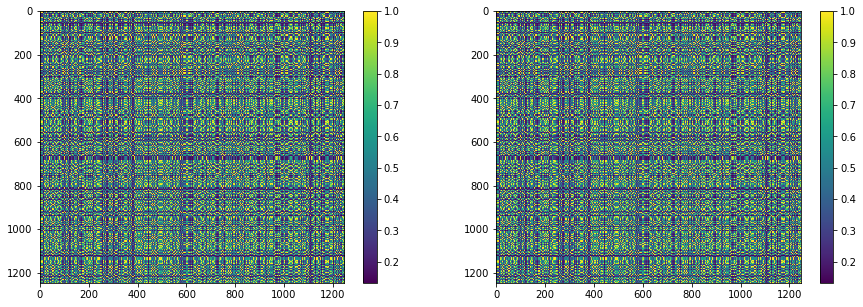

In [135]:
#Simulation template
Shat = simNoise(nvox, euclidDmat(XY[:,1]), Phat[1], 'euclidC' )

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.imshow(Shat['C'], aspect = 'auto')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(S['C'], aspect = 'auto')
plt.colorbar()